In [1]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=1280"

import jax
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
import seaborn as sns

from blackjax import ghmc, meads

# from jax.config import config


# config.update("jax_debug_nans", True)
# config.update("jax_enable_x64", True)

In [2]:
def inference_loop(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)

    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

In [3]:
# logprob_fn = lambda x: -0.5 * jnp.dot(x, x)
logprob = lambda x1, x2: -0.5 * ((x1 - 2) ** 2 / 2 + (x2 + 1) ** 2 / 0.5)
logprob_fn = lambda x: logprob(**x)
num_batch = 10
batch_size = 128

n_warm = 10
n_iter = 10000

In [4]:
init, kernel = ghmc(logprob_fn, {"x1": 1.0, "x2": 1.0}, 1.0, 0.5)
key_init, key_position1, key_position2, key_sample = jrnd.split(jrnd.PRNGKey(0), 4)
init_state = init(
    key_init, {"x1": jrnd.normal(key_position1), "x2": jrnd.normal(key_position2)}
)
states, infos = inference_loop(key_sample, init_state, kernel, n_iter)
samples = states.position

In [7]:
eca = False
batch_fn = jax.vmap
warmup = meads(
    ghmc, logprob_fn, num_batch, batch_size, n_warm, eca=eca, batch_fn=batch_fn
)


def get_initial_positions(rng):
    rngs = jrnd.split(rng, batch_size * (1 if eca else num_batch))
    rngs2 = jrnd.split(rng, batch_size * (1 if eca else num_batch))
    return batch_fn(lambda k1, k2: {"x1": jrnd.normal(k1), "x2": jrnd.normal(k2)})(
        rngs, rngs2
    )


#     return jax.pmap(lambda k: jrnd.normal(k, (2,)))(rngs)

if eca:
    rng_keys = jrnd.split(jrnd.PRNGKey(0), num_batch)
    init_positions = batch_fn(get_initial_positions)(rng_keys)
else:
    rng_keys = [jrnd.PRNGKey(0)]
    init_positions = get_initial_positions(rng_keys[0])
k_warm, k_sample = jrnd.split(rng_keys[0])
last_state, kernel, warmup_states = warmup.run(k_warm, init_positions)
states, infos = inference_loop(k_sample, init_state, kernel, n_iter)
samples = states.position

In [6]:
# SAMPLES FROM MEADS
x1_sample = warmup_states.states.position["x1"][-1].reshape((-1,))
x2_sample = warmup_states.states.position["x2"][-1].reshape((-1,))

In [8]:
# SAMPLES FROM GHMC (FIXED PARAM)
x1_sample = samples["x1"]
x2_sample = samples["x2"]

In [9]:
key = jrnd.PRNGKey(0)
k1, k2 = jrnd.split(key)
x1 = jnp.sqrt(2) * jrnd.normal(k1, shape=x1_sample.shape) + 2
x2 = jnp.sqrt(0.5) * jrnd.normal(k2, shape=x2_sample.shape) - 1

<AxesSubplot:>

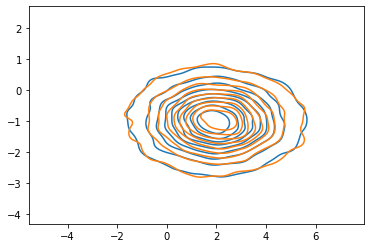

In [10]:
sns.kdeplot(x=x1, y=x2)
sns.kdeplot(x=x1_sample, y=x2_sample)

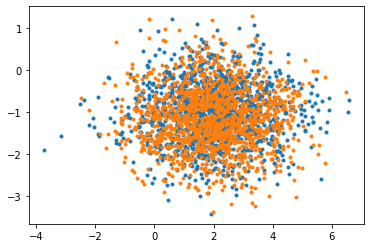

In [9]:
plt.plot(x1, x2, ".")
plt.plot(x1_sample, x2_sample, ".")
plt.show()